# Plant Pathology

## Purpose 
The Plant Pathology 2021-FGVC8 challenge aims to automate the process of identifying diseases in apple leaves through images. Currently, disease identification largely depends on manual inspection, which is both time-consuming and costly. The goal of this competition is to develop machine learning models that can accurately classify images of apple leaves into various disease categories based on their visual symptoms. ([https://www.kaggle.com/competitions/plant-pathology-2021-fgvc8/overview](https://www.kaggle.com/competitions/plant-pathology-2021-fgvc8/overview))

## Data
* **Dataset Size:** Approximately 23,000 high-quality RGB images of apple leaves.
* **Variability:** The images represent a range of real-world conditions, including different apple cultivars, stages of leaf maturity, and varying environmental conditions such as lighting and background.
* **Complexity:** The dataset includes images with single and multiple disease symptoms per leaf. Some leaves are classified under a "complex" category due to multiple diseases that make visual classification challenging.
* **Training Data:** Labeled images with annotations for disease presence and categories.
* **Test Data:** A hidden set of around 5,000 images that will be used to evaluate the performance of the submitted models.

## Import libraries

In [58]:
# import libraries
import os 
import pandas as pd
import numpy as np
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical

## Read in Data

In [60]:
dir_name = 'data'

if not os.path.exists(dir_name):
    os.makedirs(dir_name)

zip_file_path = 'plant-pathology-2021-fgvc8.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(dir_name)

## Data Exploration

### Check Label Distribution

In [ ]:
train_label = pd.read_csv('data/train.csv')
train_label.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [ ]:
# Create a dictionary mapping image file paths to their respective labels
label_dict = dict(zip(train_label['image'], train_label['labels']))

### View some of the images

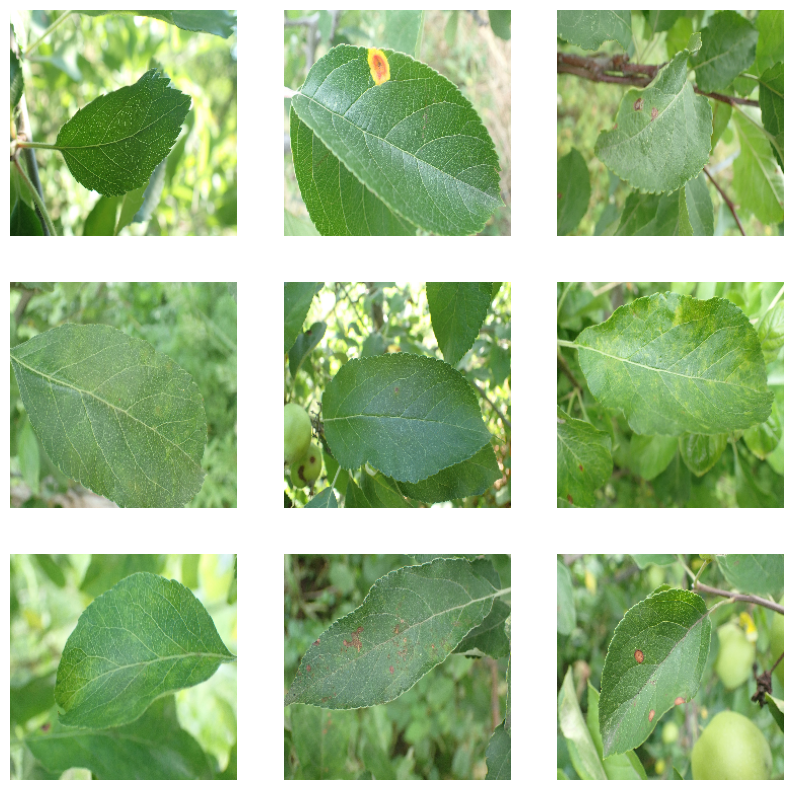

In [ ]:
train_images = tf.data.Dataset.list_files('data/train_images/*.jpg')

def process_image(file_path):
    # Read the image file
    image = tf.io.read_file(file_path)
    # Decode the image as JPEG
    image = tf.image.decode_jpeg(image, channels=3)
    # Cast the image to float32
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    # Resize the image if needed (here resizing to 224x224)
    image = tf.image.resize(image, [224, 224])
    return image

# Apply the processing function to each item in the dataset
train_dataset = train_images.map(process_image)

# Display a few images
def display_images(dataset):
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(dataset.take(9)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.axis("off")
    plt.show()

display_images(train_dataset)


### Brightness Distribution

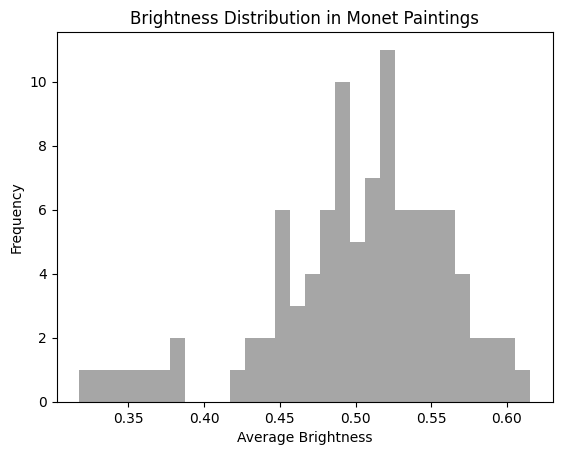

In [ ]:
def plot_brightness_distribution(dataset):
    brightness_values = []
    for image in dataset.take(100):
        brightness = tf.reduce_mean(image).numpy()
        brightness_values.append(brightness)

    plt.hist(brightness_values, bins=30, color='gray', alpha=0.7)
    plt.title('Brightness Distribution in Monet Paintings')
    plt.xlabel('Average Brightness')
    plt.ylabel('Frequency')
    plt.show()

plot_brightness_distribution(train_dataset)

### Label Distribution

In [ ]:
# distribution of labels and histogram
train_label['labels'].value_counts()


labels
scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: count, dtype: int64

<Axes: xlabel='labels'>

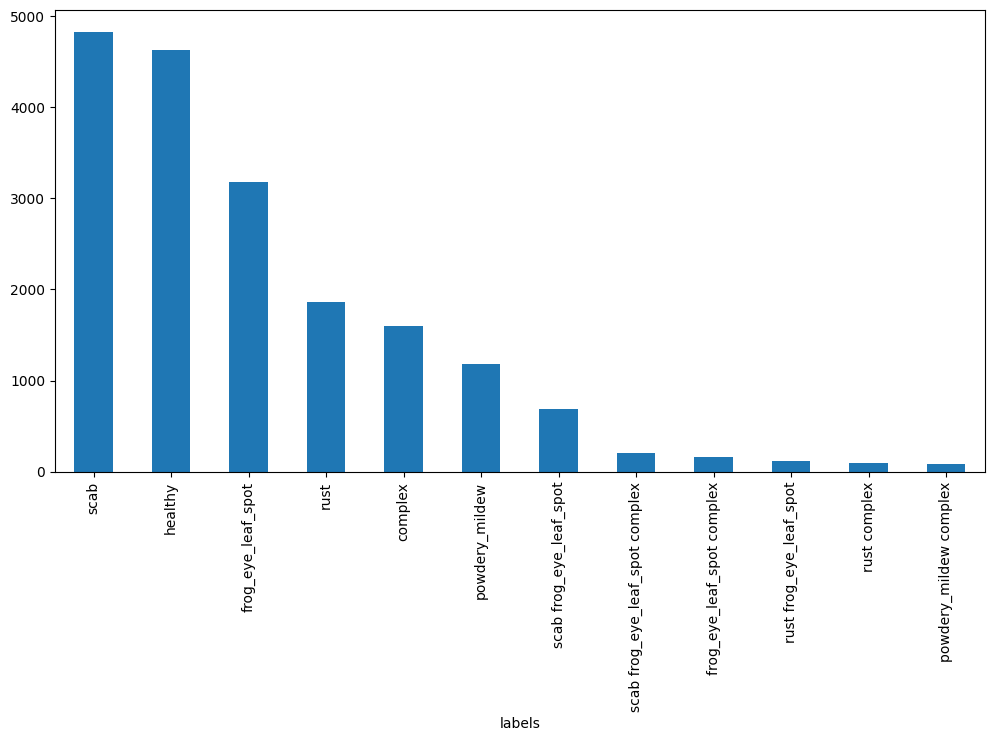

In [ ]:
# histogram of the labels
plt.figure(figsize=(12, 6))
train_label['labels'].value_counts().plot(kind='bar')

## Model Architecture

For the Plant Pathology 2021-FGVC8 challenge, we will use a Convolutional Neural Network (CNN) utilizing the ResNet50 model pre-trained on ImageNet (ImageNet is a large-scale visual database) as a feature extractor to classify the images of apple leaves into different disease categories. 

**Model Choice**
Given the complexity of the dataset and the task (multiple diseases, high variability in images), a pre-trained deep learning model could be advantageous. Pre-trained models have already learned rich feature representations for a wide range of images, which can be beneficial for a specialized task like plant pathology. 

**Model Architecture**
The ResNet50 model will serve as the feature extractor, where the final layers can be fine-tuned for our specific task.

In [ ]:
# Load the pre-trained ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Adding the custom top layers for the classification on top of the base model
model = Sequential([
    base_model,
    Flatten(), # flatten layer to convert 3D data to 1D
    Dense(256, activation='relu'), # dense layer applying relu activation function
    Dropout(0.5),  # apply dropout to prevent overfitting
    Dense(len(train_label['labels'].unique()), activation='softmax')  # Adjust the number of classes based on the unique labels
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

### Checking all the files are in the label file 

In [ ]:
# Get the list of file names in the train_images folder
train_images_names = os.listdir('data/train_images')

# Load the train_labels DataFrame
# Get the list of image names from the DataFrame
train_labels_names = train_label['image'].tolist()

# Compare the two lists
are_same = set(train_images_names) == set(train_labels_names)

print('The image names in the train_images folder and the train_labels DataFrame are the same:', are_same)

The image names in the train_images folder and the train_labels DataFrame are the same: True


In [ ]:
# Find differences between the two sets
difference_in_directory = set(train_images_names) - set(train_labels_names)
difference_in_dataframe = set(train_labels_names) - set(train_images_names)

print('Files in directory not in DataFrame:', difference_in_directory)
print('Files in DataFrame not in directory:', difference_in_dataframe)


Files in directory not in DataFrame: set()
Files in DataFrame not in directory: set()


### Preparing Data

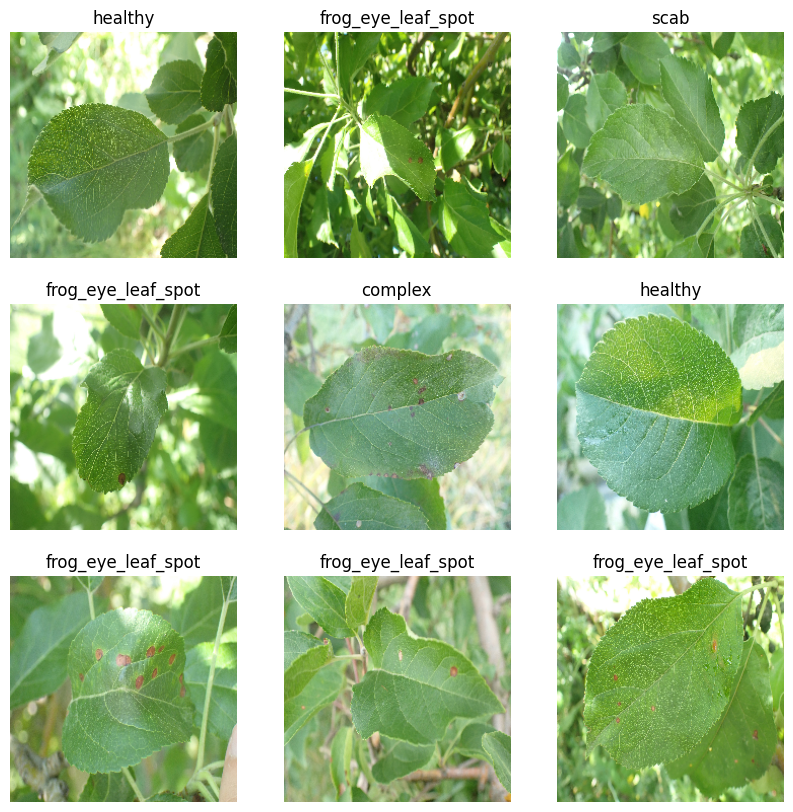

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
train_label['encoded_labels'] = label_encoder.fit_transform(train_label['labels'])

# Split data into training and validation sets
train_df, valid_df = train_test_split(train_label, test_size=0.2, random_state=42)

def process_image(file_path):
    # Read and decode the image
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    # Resize and normalize the image
    image = tf.image.resize(image, [224, 224])  # Resize images to 224x224
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1] range
    return image

def load_and_preprocess_image(file_path, label):
    return process_image(file_path), label

# Setup file paths and labels for TensorFlow datasets
train_file_paths = 'data/train_images/' + train_df['image']
train_labels = train_df['encoded_labels'].values
valid_file_paths = 'data/train_images/' + valid_df['image']
valid_labels = valid_df['encoded_labels'].values

# Create TensorFlow datasets
train_data = tf.data.Dataset.from_tensor_slices((train_file_paths, train_labels))
train_data = train_data.map(load_and_preprocess_image).shuffle(1000).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

valid_data = tf.data.Dataset.from_tensor_slices((valid_file_paths, valid_labels))
valid_data = valid_data.map(load_and_preprocess_image).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# Display function to visualize some training images
def display_images(dataset):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i])
            plt.title(label_encoder.inverse_transform([labels[i].numpy()])[0])
            plt.axis("off")
    plt.show()

# Display some images
display_images(train_data)

## Model Training

In [ ]:
# Training the model
history = model.fit(
    train_data,
    epochs=10,  # Increase the number of epochs as needed
    validation_data=valid_data
)

Epoch 1/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 819s 2s/step - accuracy: 0.2382 - loss: 3.2643 - val_accuracy: 0.2605 - val_loss: 1.9229
Epoch 2/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 754s 2s/step - accuracy: 0.2623 - loss: 2.0739 - val_accuracy: 0.2635 - val_loss: 1.9205
Epoch 3/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 757s 2s/step - accuracy: 0.2620 - loss: 1.9905 - val_accuracy: 0.2688 - val_loss: 1.8833
Epoch 4/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 756s 2s/step - accuracy: 0.2663 - loss: 1.9560 - val_accuracy: 0.2852 - val_loss: 1.8694
Epoch 5/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 760s 2s/step - accuracy: 0.2609 - loss: 1.9305 - val_accuracy: 0.2528 - val_loss: 1.9439
Epoch 6/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 759s 2s/step - accuracy: 0.2662 - loss: 1.9474 - val_accuracy: 0.2528 - val_loss: 1.9210
Epoch 7/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 762s 2s/step - accuracy: 0.2651 - loss: 1.9297 - val_accuracy: 0.2528 - val_loss: 1.9119
Epoch 8/10
466/466 ━━━━━━━━━━━━━━━━━━━━ 761s 2s/step - accuracy: 0.2635 - loss: 1.9214 - val_accu

### Monitoring Training Process

**Training and Validation Accuracy:**
* The training accuracy is fluctuating significantly, and the validation accuracy is consistently lower than the training accuracy.
* The highest peak of accuracy is still very low (below 30%), which suggests that the model is not learning effectively from the data.
* The close alignment of training and validation accuracy could typically be a good sign (indicating no overfitting), but since the accuracy is so low, it likely points to underfitting.

**Training and Validation Loss:**
* The training loss decreases sharply and then levels off, which is expected behavior as the model begins to learn from the data.
* The validation loss, after initially decreasing, shows a slight increase and then runs mostly parallel to the training loss.
* The validation loss is higher than the training loss, which might indicate that the model is not generalizing well. However, both losses remain high, reinforcing the underfitting problem.

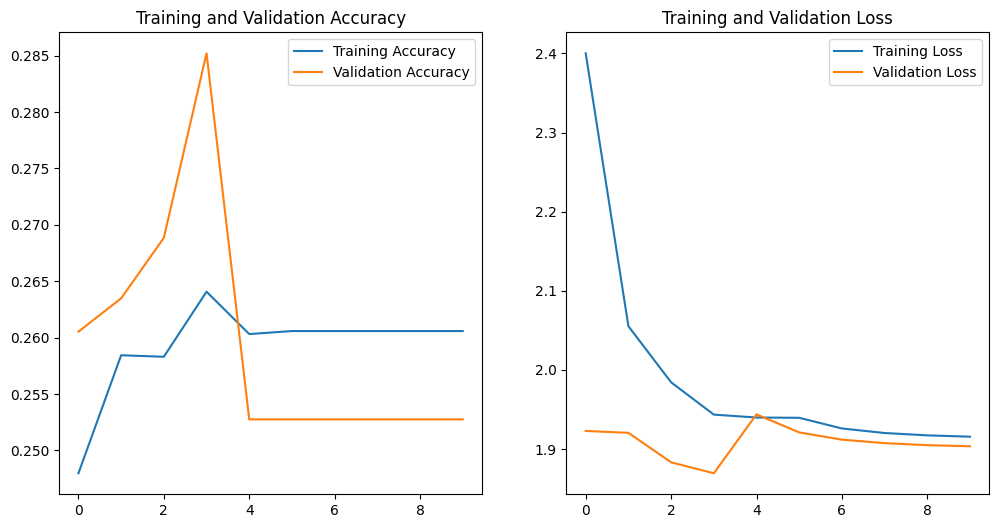

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_training_history(history)


**Potential Issues and Solutions:**
* Underfitting: The model is not capturing the underlying patterns in the data. Solutions could include:
    * Increasing model complexity: Might need a deeper network or more neurons in your Dense layers.
* Insufficient Training: The model may require more epochs to learn effectively, or it may benefit from a learning rate schedule that decreases the learning rate over time.

### Increasing Model Complexity

In [ ]:
# Adding a more complex top model
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),  # Increase to 512 units
    Dropout(0.5),
    Dense(256, activation='relu'),  # New additional dense layer
    Dropout(0.5),
    Dense(len(np.unique(train_label['encoded_labels'])), activation='softmax')  # Number of classes
])


### Adjusting Model

In [ ]:
# Use a learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1))
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Train for more epochs
epochs = 20  # Increase the epochs

# Compile the model with possibly a lower initial learning rate if needed
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Starting with a smaller learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=valid_data,
    callbacks=[callback]  # Add the scheduler to the callbacks
)

Epoch 1/20


466/466 ━━━━━━━━━━━━━━━━━━━━ 831s 2s/step - accuracy: 0.2663 - loss: 1.8880 - val_accuracy: 0.2828 - val_loss: 1.8435 - learning_rate: 1.0000e-04
Epoch 2/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 826s 2s/step - accuracy: 0.2649 - loss: 1.8860 - val_accuracy: 0.2815 - val_loss: 1.8673 - learning_rate: 1.0000e-04
Epoch 3/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 824s 2s/step - accuracy: 0.2676 - loss: 1.8846 - val_accuracy: 0.2608 - val_loss: 1.8983 - learning_rate: 1.0000e-04
Epoch 4/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 823s 2s/step - accuracy: 0.2734 - loss: 1.8907 - val_accuracy: 0.2530 - val_loss: 1.9119 - learning_rate: 1.0000e-04
Epoch 5/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 831s 2s/step - accuracy: 0.2681 - loss: 1.9022 - val_accuracy: 0.2608 - val_loss: 1.8988 - learning_rate: 1.0000e-04
Epoch 6/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 838s 2s/step - accuracy: 0.2650 - loss: 1.8998 - val_accuracy: 0.2801 - val_loss: 1.8436 - learning_rate: 1.0000e-04
Epoch 7/20
466/466 ━━━━━━━━━━━━━━━━━━━━ 828s 2s/step - accuracy: 0.26

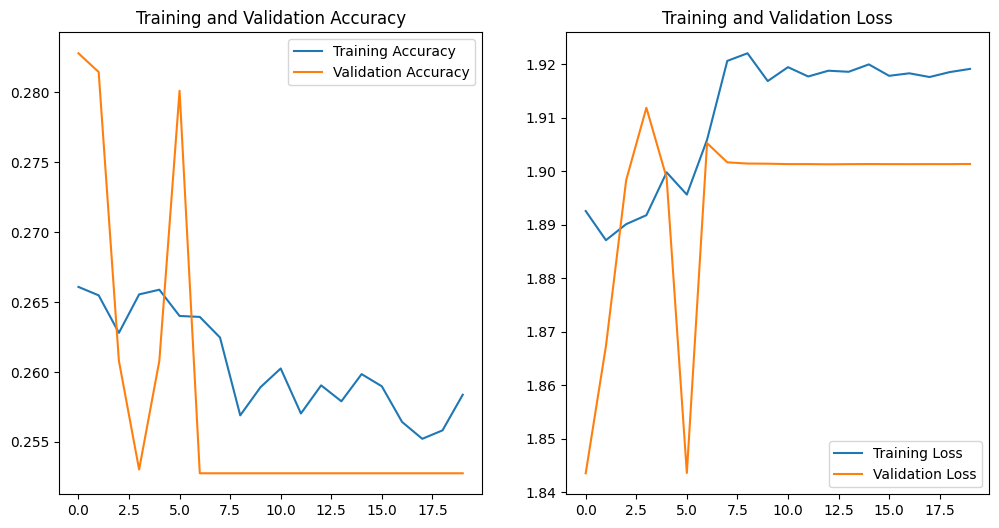

In [ ]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_training_history(history)


* The training accuracy is still quite low, generally hovering around 26%-28%, which is an indicator that the model is not learning effectively.
* The accuracy shows high volatility, with sharp spikes, which could suggest issues with the training data, label encoding, or possibly the learning rate still being too high, causing instability in learning.
* The validation accuracy follows the training accuracy but does not show significant improvement over time. It remains lower than the training accuracy, suggesting the model has not generalized well.
* The training loss decreases initially but then plateaus, suggesting that the model might not be improving after a certain point in training.
* The validation loss is unstable, with sharp increases and decreases. Overall, it does not show an improving trend, which should typically be downwards.
* The validation loss being close to the training loss suggests the model isn't overfitting, but since both are high, the model is likely underfitting.

## Results/Conclusion


**Results**
Our initial model showed signs of underfitting, as indicated by low training and validation accuracies, with a maximum accuracy peak below 30%. After enhancing the model complexity by adding additional dense layers and employing a learning rate scheduler, the performance exhibited minor improvements, but the overall accuracy remained low, suggesting that the model was still unable to capture the complexity of the data.

**Conclusion**
Despite our efforts to refine the model through architectural changes and hyperparameter tuning, the model's performance did not meet the expected standards. This outcome suggests several potential areas for further investigation and improvement:

Hyperparameter Optimization: A more thorough hyperparameter optimization process could lead to better model tuning.
Advanced Techniques: Incorporating techniques such as ensemble methods, or using domain-specific feature engineering, could be explored to boost performance.
